# Classification Evaluation

## Import dataset (h5py)

In [16]:
import os
import h5py


"""
Data path
"""
data_train_path = os.path.abspath('../../new_dataset/dataset/dataset_20181203_01/train.h5')
data_vali_path = os.path.abspath('../../new_dataset/dataset/dataset_20181203_01/vali.h5')
data_test_path = os.path.abspath('../../new_dataset/dataset/dataset_20181203_01/test.h5')


"""
Import ".h5" data
"""
data = []
class_label = []
heading_label = []

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    class_label = f['class'][:]
    heading_label = f['heading'][:]
    return (data, class_label, heading_label)

data_train, class_label_train, heading_label_train = load_h5(data_train_path)
data_vali, class_label_vali, heading_label_vali = load_h5(data_vali_path)
data_test, class_label_test, heading_label_test = load_h5(data_test_path)

data.append(data_train)
data.append(data_vali)
data.append(data_test)

class_label.append(class_label_train)
class_label.append(class_label_vali)
class_label.append(class_label_test)

heading_label.append(heading_label_train)
heading_label.append(heading_label_vali)
heading_label.append(heading_label_test)

## Data analysis

#### The number of the dataset

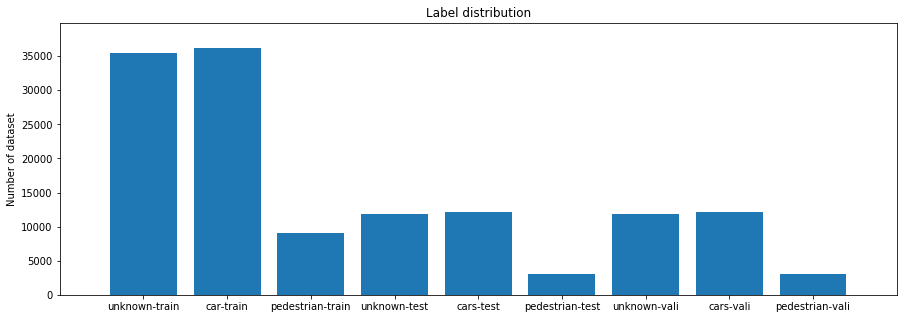

In [3]:
import numpy as np
import matplotlib.pyplot as plt


""" 
Data statistics
"""
label_list = [0, 1, 2]


y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(class_label[i] == label_list[j]))

        
"""
Label 
"""
x_name=('unknown-train', 'car-train', 'pedestrian-train',
        'unknown-test', 'cars-test', 'pedestrian-test',
        'unknown-vali', 'cars-vali', 'pedestrian-vali')

index = range( len(x_name) )

"""
Plotting 
"""
%matplotlib inline
plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

#### Label distribution

80760
26940
27000


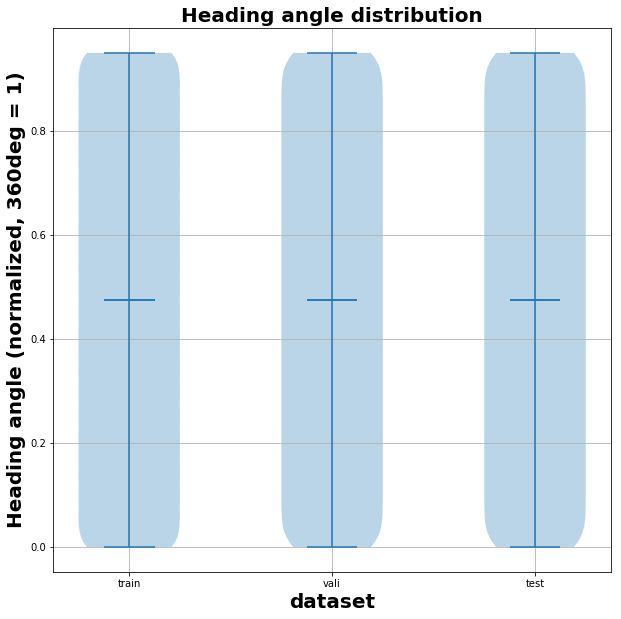

80760
26940
27000


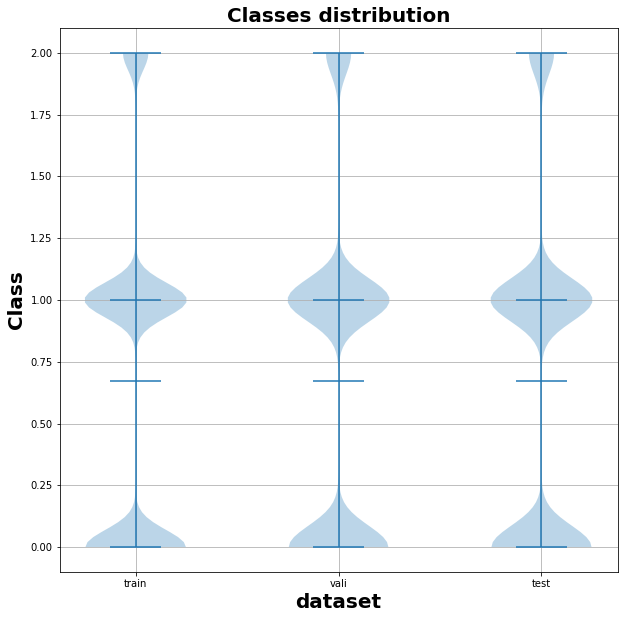

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

""" 
Dataset distribution 
"""

num_point_dist_train = []

dataset_name = {'train':0, 'vali':1, 'test':2}

for i in range( len( data_train) ):
    num_point_dist_train.append([0, class_label_train[i].item(0), heading_label_train[i].item(0)] )
    
for i in range( len( data_vali) ):
    num_point_dist_train.append([1, class_label_vali[i].item(0), heading_label_vali[i].item(0)] )
    
for i in range( len( data_test) ):
    num_point_dist_train.append([2, class_label_test[i].item(0), heading_label_test[i].item(0)] )

df = pd.DataFrame(num_point_dist_train, columns = ['dataset', 'classes', 'heading'])



"""
Plotting Heading angle
"""
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,10))

print len(df.heading[df.dataset == 0])
print len(df.heading[df.dataset == 1])
print len(df.heading[df.dataset == 2])

ax.violinplot([df.heading[df.dataset == 0], 
               df.heading[df.dataset == 1], 
               df.heading[df.dataset == 2]],showmeans=True, showmedians=True)
ax.grid()
plt.setp(ax, xticks=[1,2,3], xticklabels=['train', 'vali', 'test'])
ax.set_title("Heading angle distribution", fontsize = 20, fontweight='bold')
ax.set_xlabel("dataset", fontsize = 20, fontweight='bold')
ax.set_ylabel("Heading angle (normalized, 360deg = 1)", fontsize = 20, fontweight='bold')
plt.show()

"""
Plotting class distribution
"""
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,10))

print len(df.classes[df.dataset == 0])
print len(df.classes[df.dataset == 1])
print len(df.classes[df.dataset == 2])

ax.violinplot([df.classes[df.dataset == 0], 
               df.classes[df.dataset == 1], 
               df.classes[df.dataset == 2]],showmeans=True, showmedians=True)
ax.grid()
plt.setp(ax, xticks=[1,2,3], xticklabels=['train', 'vali', 'test'])
ax.set_title("Classes distribution", fontsize = 20, fontweight='bold')
ax.set_xlabel("dataset", fontsize = 20, fontweight='bold')
ax.set_ylabel("Class", fontsize = 20, fontweight='bold')
plt.show()

## Classification results

#### Run classification

In [51]:
import os, sys
import tensorflow as tf

""" 
Import model 
"""
sys.path.append( os.path.abspath('../../Network/model') )
from train import *
import model_out_5_heading as MODEL


model_path = os.path.abspath('../../Network/notebook/train_log_20181204/model_out5_4/model.ckpt')


# Data normalization and resampling
def NormalizeResample(data, num_sample):
    """ data is in N x ...
    we want to keep num_samplexC of them.
    if N > num_sample, we will randomly keep num_sample of them.
    if N < num_sample, we will randomly duplicate samples.
    """
    
    ## normalizing   
    x_min = float(data[:,0].min())
    x_max = float(data[:,0].max())
    y_min = float(data[:,1].min())
    y_max = float(data[:,1].max())
    z_min = float(data[:,2].min())
    z_max = float(data[:,2].max())

    scale_val = np.max([ x_max - x_min , y_max - y_min , z_max - z_min ])
    offset_val = np.min([x_min, y_min, z_min])

    data[:,0] = data[:,0] - min_val
    data[:,1] = data[:,1] - min_val
    data[:,2] = data[:,2] - min_val

    data[:,0] = data[:,0] / float(scale_val)
    data[:,1] = data[:,1] / float(scale_val)
    data[:,2] = data[:,2] / float(scale_val)
                 
    ## resampling
    N = data.shape[0]
    if (N == num_sample):
        return data
    elif (N > num_sample):
        sample = np.random.choice(N, num_sample)
        return data[sample, ...]
    else:
        sample = np.random.choice(N, num_sample-N)
        dup_data = data[sample, ...]
        return np.concatenate([data, dup_data], 0)
    

"""
Classification
"""

# Training parameters
is_training = False
GPU_INDEX = 0
NUM_POINT = 1024
NUM_CLASSES = 3
BATCH_SIZE = 100

# reset graph
tf.reset_default_graph()

with tf.device('/gpu:'+str(GPU_INDEX)):
    pointclouds_pl, labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
    is_training_pl = tf.placeholder(tf.bool, shape=())

    # model
    pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl)

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = True

ops = {'pointclouds_pl': pointclouds_pl,
       'is_training_pl': is_training_pl,
       'pred': pred}

sess = tf.Session(config=config)

# Restore variables from disk.
saver.restore(sess, model_path)
print "Model restored"

sys.stdout.flush()


dataset_list = ['train', 'vali', 'test']


class_results_list = []
heading_results_list = []


for i in range ( len ( data ) ):
    
    current_data = data[i]
    current_class_label = class_label[i]
    current_heading_label = heading_label[i]
    
    num_batches = current_data.shape[0] // BATCH_SIZE
    
    class_results = []
    heading_results = []

    
    sys.stdout.flush()
    num_batches = 1
    for batch_idx in trange(num_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = (batch_idx+1) * BATCH_SIZE

        feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx].reshape((BATCH_SIZE, NUM_POINT, 3)),
                     ops['is_training_pl']: is_training}
        
        pred_val = sess.run([ops['pred']], feed_dict=feed_dict )
        
        # heading
        heading_results.extend(pred_val[0][:,3])
        
        pred_val_class = np.argmax(pred_val[0][:,:3], 1)
        class_results.extend(pred_val_class)
        
        
    class_results_list.append(class_results)
    heading_results_list.append(heading_results)

INFO:tensorflow:Restoring parameters from /media/kyungpyo/SmartCarContest/MasterThesisProject/Network/notebook/train_log_20181204/model_out5_4/model.ckpt
Model restored


100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


#### Analysis classification results

---------------------------------------
----------- Classification ------------
---------------------------------------
---------------------------------------
Train
---------------------------------------
             precision    recall  f1-score   support

    unknown       0.98      0.96      0.97        45
        car       1.00      0.98      0.99        42
      pedes       0.87      1.00      0.93        13

avg / total       0.97      0.97      0.97       100

Confusion matrix, without normalization


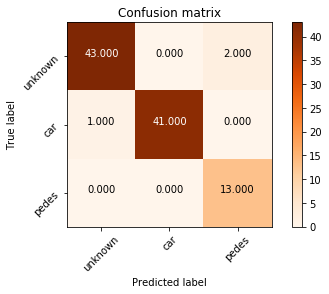

---------------------------------------
Validation
---------------------------------------
             precision    recall  f1-score   support

    unknown       0.93      0.93      0.93        44
        car       1.00      1.00      1.00        47
      pedes       0.67      0.67      0.67         9

avg / total       0.94      0.94      0.94       100

Confusion matrix, without normalization


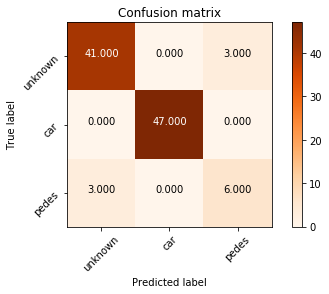

---------------------------------------
Test
---------------------------------------
             precision    recall  f1-score   support

    unknown       0.92      0.96      0.94        47
        car       1.00      0.94      0.97        48
      pedes       0.67      0.80      0.73         5

avg / total       0.94      0.94      0.94       100

Confusion matrix, without normalization


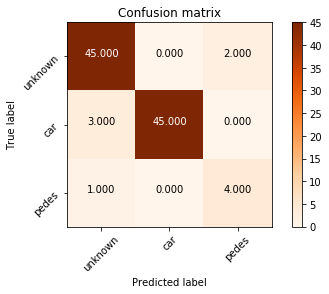

---------------------------------------
------------ Regression ---------------
---------------------------------------
---------------------------------------
Train
---------------------------------------
- Root mean_squared_errors [deg]: 1.9369523786


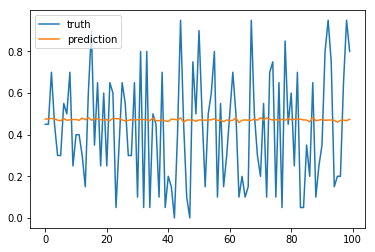

---------------------------------------
Validation
---------------------------------------
- Root mean_squared_errors [deg]: 3.47966697067


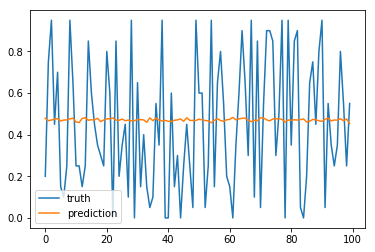

---------------------------------------
Test
---------------------------------------
- Root mean_squared_errors [deg]: 2.37367870286


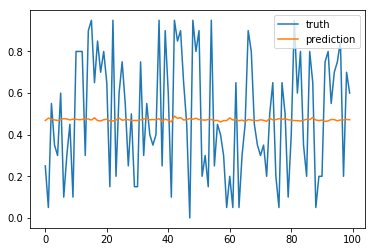

In [67]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from visualization import *

"""
Classification results
"""

print "---------------------------------------"
print "----------- Classification ------------"
print "---------------------------------------"

dataset_list = ['Train', 'Validation', 'Test']

for i in range ( len ( class_label ) ):
    
    print "---------------------------------------"
    print dataset_list[i]
    print "---------------------------------------"

    prediction = np.array(class_results_list[i])
    ground_truth = np.array(class_label[i][:len(prediction)])

    cm = confusion_matrix(ground_truth, prediction)

    label_list = ['unknown', 'car', 'pedes']
    print(classification_report(ground_truth, prediction, target_names=label_list))

    %matplotlib inline
    plot_confusion_matrix(cm, normalize = False, title='Confusion matrix', cmap=plt.cm.Oranges, label_list = label_list)
    plt.show()
    
"""
Regression results
"""

print "---------------------------------------"
print "------------ Regression ---------------"
print "---------------------------------------"

for i in range ( len ( class_label ) ):

    
    print "---------------------------------------"
    print dataset_list[i]
    print "---------------------------------------"

    
    y_pred = np.asarray(heading_results_list[i])
    y_true = np.asarray(heading_label[i][:len(y_pred)])
    
    y_pred = y_pred.reshape(y_true.shape)
    
    error = np.min([np.abs(y_true - y_pred), np.abs(y_true - y_pred - 1)], axis = 0)
    rmse = np.square( np.mean (error**2) )


#     print('- Explained_variance_score: {}'.format(explained_variance_score(y_true, y_pred)))
#     print('- R2_score: {}'.format(r2_score(y_true, y_pred)))
    
    print('- Root mean_squared_errors [deg]: {}'.format(rmse * 360.))
    %matplotlib inline
    plt.plot(y_true, label = 'truth')
    plt.plot(y_pred, label = 'prediction')
    plt.legend()
    plt.show()


#### Visualization point cloud data

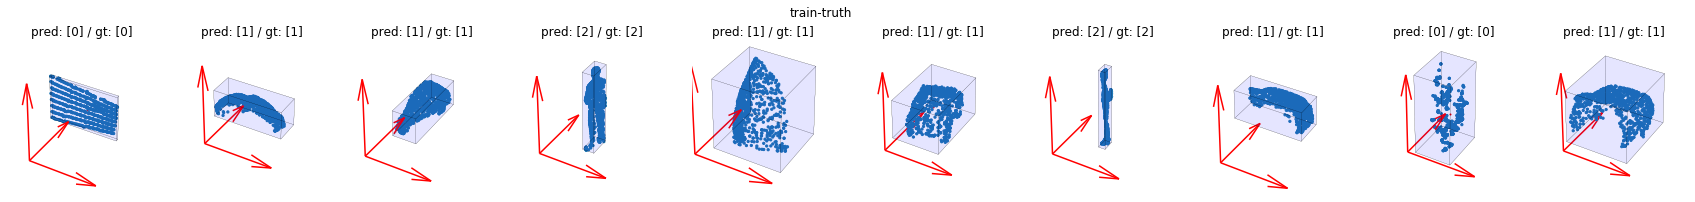

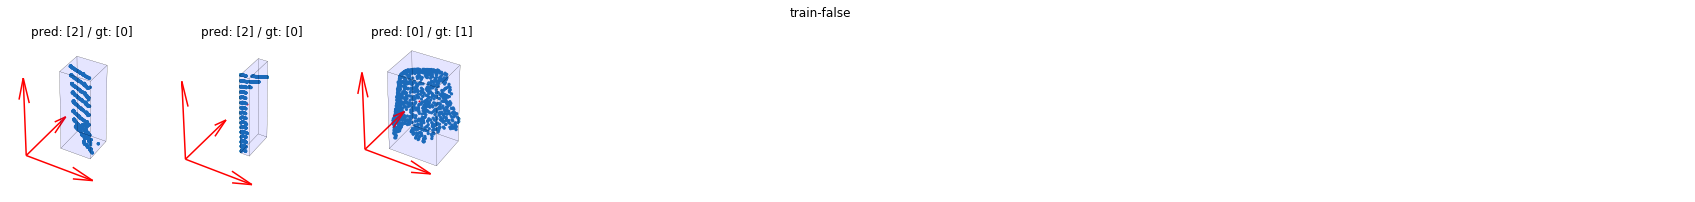

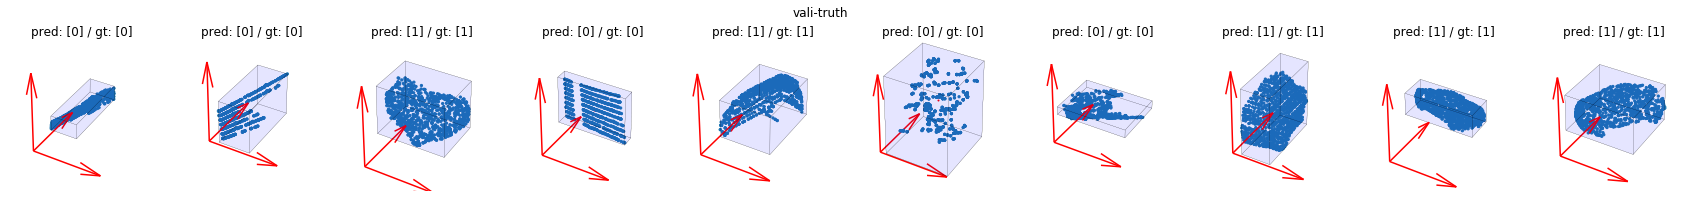

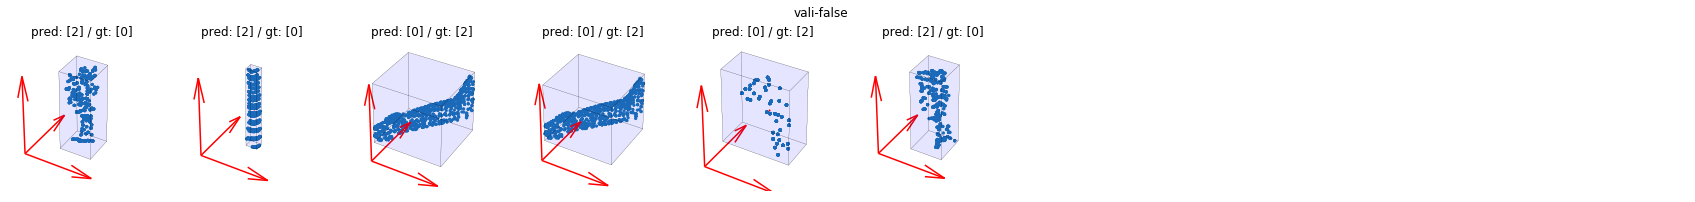

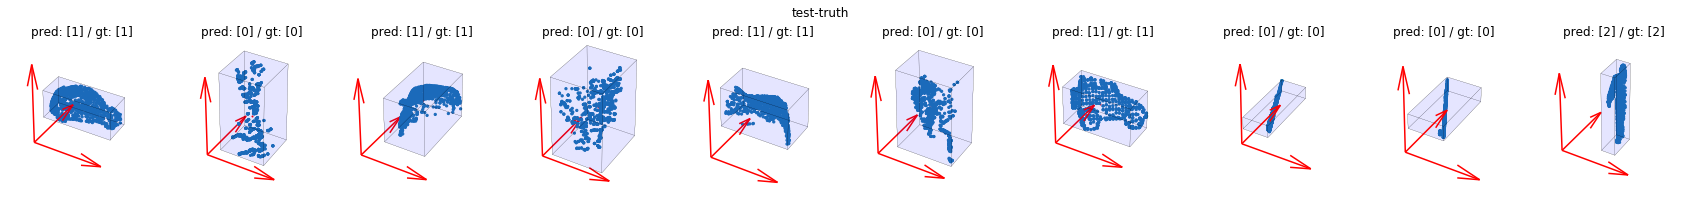

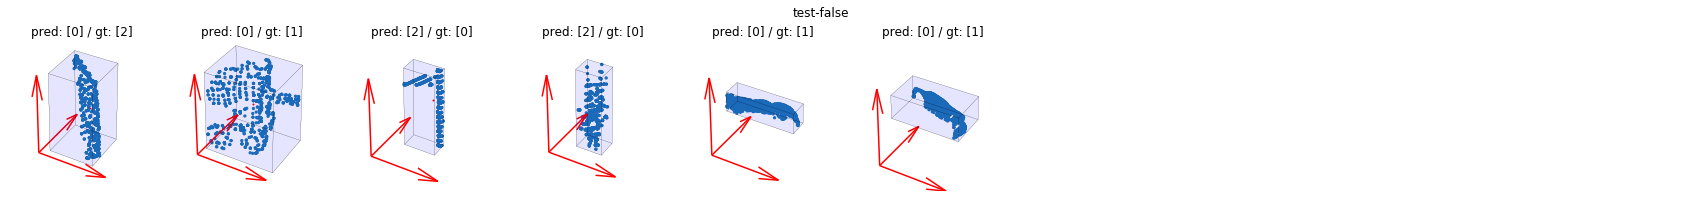

In [47]:
import numpy
from visualization import *


dataset_list = ['train', 'vali', 'test']
num_vis = 10

for i in range ( len ( class_label ) ):

    """
    Dataset parsing
    """
    prediction = np.array(results_list[i])
    ground_truth = np.array(class_label[i][:len(results_list[i])])
    prediction = prediction.reshape(ground_truth.shape)
    pointcloud_data = data[i][:len(results_list[i])]
    
    truth_data = pointcloud_data[np.squeeze(prediction == ground_truth)]
    truth_data_label_pred = prediction[[np.squeeze(prediction == ground_truth)]]
    truth_data_label_gt = ground_truth[[np.squeeze(prediction == ground_truth)]]
    
    false_data = pointcloud_data[np.squeeze(prediction != ground_truth)]
    false_data_label_pred = prediction[[np.squeeze(prediction != ground_truth)]]
    false_data_label_gt = ground_truth[[np.squeeze(prediction != ground_truth)]]
    
    
    """
    Plot truth case
    """
    fig = plt.figure(figsize = (num_vis*3, 3))
    
    fig.suptitle(dataset_list[i] + "-truth")
    
    for j in range(0, num_vis):
        
        if j < len(truth_data):
            
            ax = fig.add_subplot(1,num_vis,j+1, projection='3d')
            ax.set_title("pred: {} / gt: {}".format(truth_data_label_pred[j], truth_data_label_pred[j]))

            display_point_cloud_box_ax_test(ax, truth_data[j])

            plt.axis('off')
        else:
            ax = fig.add_subplot(1,num_vis,j+1, projection='3d')
            plt.axis('off')
            

    plt.show()
    
    
    """
    Plot flase case
    """
    fig = plt.figure(figsize = (num_vis*3, 3))
    
    fig.suptitle(dataset_list[i] + "-false")
    
    for j in range(0, num_vis):
        
        if j < len(false_data):
            
            ax = fig.add_subplot(1,num_vis,j+1, projection='3d')
            ax.set_title("pred: {} / gt: {}".format(false_data_label_pred[j], false_data_label_gt[j]))

            display_point_cloud_box_ax_test(ax, false_data[j])

            plt.axis('off')
        else:
            ax = fig.add_subplot(1,num_vis,j+1, projection='3d')
            plt.axis('off')

    plt.show()
    
